In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.figure
import xgboost as xgb

%matplotlib inline

/Users/waihamyee/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data and Preprocessing

In [3]:
# Read the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [6]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,37,23,20,0,3,27,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,37,21,22,4,3,31,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,24,24,38,2,3,30,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,24,21,38,5,3,30,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,24,23,38,5,3,14,3,13,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,24,23,38,5,3,26,0,22,0,...,0,0,0,1,0,0,0,0,0,0
1,2,46,3,9,0,3,9,6,24,0,...,0,0,1,0,0,0,0,0,0,0
2,3,24,23,19,5,3,0,9,9,0,...,0,0,0,1,0,0,0,0,0,0
3,4,24,13,38,5,3,32,11,13,0,...,0,0,0,1,0,0,0,0,0,0
4,5,49,20,19,2,3,31,8,12,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
## Combine the datasets (train and test)
full_data = pd.concat([train.drop(["y"], axis=1), test])
print ("The training and testing data sets combined contains {} rows and {} columns"
       .format(full_data.shape[0], full_data.shape[1])
      )

The training and testing data sets combined contains 8418 rows and 377 columns


## Dimensionality Reduction

Let's look at the items in the training set that have the same value throughout all of our dataset.

In [6]:
## Select all columns in our train dataset that only have 1 unique value
train.loc[:,(train.apply(pd.Series.nunique) == 1)].columns.tolist()

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

What about in the test set? Are there any similar columns?

In [9]:
## Select all columns in our test dataset that only have 1 unique value
test.loc[:,(test.apply(pd.Series.nunique) == 1)].columns.tolist()

['X257', 'X258', 'X295', 'X296', 'X369']

In [7]:
from sklearn.decomposition import PCA
n_comp = 10

# PCA
pca = PCA(n_components=n_comp)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

y_train = train["y"]
y_mean = np.mean(y_train)

In [8]:
from sklearn.decomposition import FactorAnalysis

n_comp = 10

# PCA
FA = FactorAnalysis(n_components=n_comp)
FA_results_train = FA.fit_transform(train.drop(["y"], axis=1))
FA_results_test = FA.transform(test)

FA.components_


array([[ -6.47565485e+01,  -6.19630934e+00,   4.73163029e+00, ...,
         -1.35130079e-03,   3.05959072e-04,   1.85816158e-03],
       [  6.72097260e+01,  -6.01626114e-01,   2.03670469e+00, ...,
         -2.19242242e-03,  -4.72998020e-04,  -9.89930283e-04],
       [ -5.36206418e+01,  -3.12396313e+00,  -1.05051821e-01, ...,
          1.44158035e-03,  -2.97069140e-04,  -6.95869494e-05],
       ..., 
       [  6.20344231e+00,   1.25573481e+00,   5.24837369e-01, ...,
         -5.59214844e-05,  -1.06224042e-04,  -4.40734235e-04],
       [  5.11025038e+01,  -1.33196810e+00,   5.88268109e-01, ...,
         -4.79186063e-04,  -3.77536116e-05,  -2.60864471e-04],
       [ -2.43344084e+03,   3.43833006e-01,  -8.19591112e-01, ...,
          3.20798662e-04,   3.20203371e-04,  -1.19722857e-03]])

0.99999738674424321

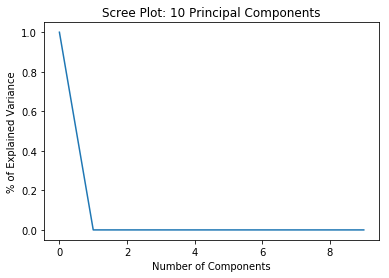

In [9]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Scree Plot: 10 Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Explained Variance")
sum(pca.explained_variance_ratio_)

In [25]:
# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(train.drop('y', axis=1).drop('ID', axis=1), y_train)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=800, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.6403	test-rmse:12.6381
[50]	train-rmse:11.1096	test-rmse:11.1392
[100]	train-rmse:10.0556	test-rmse:10.1265
[150]	train-rmse:9.34609	test-rmse:9.46525
[200]	train-rmse:8.87713	test-rmse:9.04179
[250]	train-rmse:8.56915	test-rmse:8.77551
[300]	train-rmse:8.36685	test-rmse:8.61206
[350]	train-rmse:8.23146	test-rmse:8.51185
[400]	train-rmse:8.13698	test-rmse:8.45205
[450]	train-rmse:8.06588	test-rmse:8.41758
[500]	train-rmse:8.00884	test-rmse:8.39592
[550]	train-rmse:7.95905	test-rmse:8.38431
[600]	train-rmse:7.91463	test-rmse:8.3786
[650]	train-rmse:7.87515	test-rmse:8.37763
[700]	train-rmse:7.83623	test-rmse:8.37766
680


In [ ]:
## Plot the feature importance plot
xgb.plot_importance(model).figure.set_size_inches( (15,25) )

In [23]:
# Check r2-score
from sklearn.metrics import r2_score

# now fixed, correct calculation
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.59318873897


In [222]:
# Predict and save results.
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('xgboost.csv', index=False)